In [9]:
#%pip install Pandas
#%pip install keras
#%pip install tensorflow
#%pip install scikit-learn

   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/10.6 MB 3.6 MB/s eta 0:00:03
   - -------------------------------------- 0.5/10.6 MB 6.6 MB/s eta 0:00:02
   --- ------------------------------------ 1.0/10.6 MB 7.8 MB/s eta 0:00:02
   ----- ---------------------------------- 1.5/10.6 MB 8.8 MB/s eta 0:00:02
   ------- -------------------------------- 2.1/10.6 MB 9.5 MB/s eta 0:00:01
   ---------- ----------------------------- 2.7/10.6 MB 10.1 MB/s eta 0:00:01
   ------------ --------------------------- 3.3/10.6 MB 10.5 MB/s eta 0:00:01
   -------------- ------------------------- 3.9/10.6 MB 10.7 MB/s eta 0:00:01
   ---------------- ----------------------- 4.4/10.6 MB 10.8 MB/s eta 0:00:01
   ------------------ --------------------- 5.0/10.6 MB 10.6 MB/s eta 0:00:01
   --------------------- ------------------ 5.6/10.6 MB 10.8 MB/s eta 0:00:01
   ----------------------- ---------------- 6.2/10.6 MB 11.0 MB/s eta 0:00:01

DEPRECATION: teroshdl 2.1.2 has a non-standard dependency specifier yowasp-yosys>=0.8.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of teroshdl or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import keras
import sklearn.decomposition
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.metrics


- [1. Introduction](#1-introduction)



# 1. Introduction

Predicting for how much houses will sell will help current and prospective homeowners navigate the cluttered landscape of real estate. 

# 2. Dataset

The dataset provided houses a lot of different parameters on which the price of a house can depend. Just to give a couple examples with their usual impact on the house price from general knowledge and experience:

- LotArea: the area of the land on which a house stands. In general the higher this number the higher the price.
- Bedroom: number of bedrooms above ground. In general the higher the number of bedrooms the higher the price.

There are a lot more prameters that are contained in the dataset. For more detail on this consult the data_description.txt file. 

# 3. Analysing the dataset

For this we first have to open the csv files that contain the data. In here we see that there are some columns that contain numeric data and some that do not. There are also some empty values. Before any models can be trained on the dataset we have to format it such that there are solely numeric values. In the data_description.txt file all the different kinds of non-numeric values can be found. 

In [57]:
# accessing the csv files

train_csv = pd.read_csv("./house-prices-advanced-regression-techniques/train.csv")
test_csv = pd.read_csv("./house-prices-advanced-regression-techniques/test.csv")

data_fields = train_csv.columns.values

print(train_csv.head())
print(len(data_fields))
print(test_csv.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [80]:
# formatting the data

# change the NaN values to zero

train_csv = train_csv.mask(pd.isna(train_csv), 0)
test_csv = test_csv.mask(pd.isna(test_csv), 0)

classes = { 
    "mszoning_classes"          :     ["A","C","FV","I","RH","RL","RP","RM"],
    "street_classes"            :      ["Grvl","Pave","C (all)"],
    "alley_classes"             :      ["Grvl","Pave","NA"],
    "lotshape_classes"          :      ["Reg","IR1","IR2","IR3"],
    "landcontour_classes"       :      ["Lvl","Bnk","HLS","Low"],
    "utilities_classes"         :      ["AllPub","NoSewr","NoSeWa","ELO"],
    "lotconfig_classes"         :      ["Inside","Corner","CulDSac","FR2","FR3"],
    "landslope_classes"         :      ["Gtl","Mod","Sev"],
    "neighborhood_classes"      :      ["Blmngtn","Blueste","BrDale","BrkSide","ClearCr","CollgCr","Crawfor","Edwards","Gilbert","IDOTRR","MeadowV","Mitchel","Names","NoRidge","NPkVill","NridgHt","NWAmes","OldTown","SWISU","Sawyer","SawyerW","Somerst","StoneBr","Timber","Veenker"],
    "condition1_classes"        :      ["Artery","Feedr","Norm","RRNn","RRAn","PosN","PosA","RRNe","RRAe", "NAmes"],
    "condition2_classes"        :      ["Artery","Feedr","Norm","RRNn","RRAn","PosN","PosA","RRNe","RRAe", "NAmes"],
    "bldgtype_classes"          :      ["1Fam","2FmCon","Duplx","TwnhsE","TwnhsI", "NAmes"],
    "housestyle_classes"        :      ["1Story","1.5Fin","1.5Unf","2Story","2.5Fin","2.5Unf","SFoyer","SLvl"],
    "roofstyle_classes"         :      ["Flat","Gable","Gambrel","Hip","Mansard","Shed"],
    "roofmatl_classes"          :      ["ClyTile","CompShg","Membran","Metal","Roll","Tar","WdShake","WdShngl", "2fmCon","Duplex", "Twnhs"],
    "exterior1st_classes"       :      ["AsbShng","AsphShn","BrkComm","BrkFace","CBlock","CemntBd","HdBoard","ImStucc","MetalSd","Other","Plywood","PreCast","Stone","Stucco","VinylSd","Wd Sdng","WdShing"],
    "exterior2nd_classes"       :      ["AsbShng","AsphShn","BrkComm","BrkFace","CBlock","CemntBd","HdBoard","ImStucc","MetalSd","Other","Plywood","PreCast","Stone","Stucco","VinylSd","Wd Sdng","WdShing"],
    "masvnrtype_classes"        :      ["BrkCmn","BrkFace","CBlock","None","Stone"],
    "exterqual_classes"         :      ["Ex","Gd","TA","Fa","Po"],
    "extercond_classes"         :      ["Ex","Gd","TA","Fa","Po"],
    "foundation_classes"        :      ["BrkTil","CBlock","PConc","Slab","Stone","Wood"],
    "bsmtqual_classes"          :      ["Ex","Gd","TA","Fa","Po","NA", "Tar&Grv"],
    "bsmtcond_classes"          :      ["Ex","Gd","TA","Fa","Po","NA"],
    "bsmtexposure_classes"      :      ["Gd","Av","Mn","No","NA", "Wd Shng", "CmentBd", "Brk Cmn"],
    "bsmtfintype1_classes"      :      ["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"],
    "bsmtfintype2_classes"      :      ["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"],
    "heating_classes"           :      ["Floor","GasA","GasW","Grav","OthW","Wall"],
    "heatingqc_classes"         :      ["Ex","Gd","TA","Fa","Po"],
    "centralair_classes"        :      ["N", "Y"],
    "electrical_classes"        :      ["SBrkr","FuseA","FuseF","FuseP","Mix"],
    "kitchenqual_classes"       :      ["Ex","Gd","TA","Fa","Po"],
    "functional_classes"        :      ["Typ","Min1","Min2","Mod","Maj1","Maj2","Sev","Sal"],
    "fireplacequ_classes"       :      ["Ex","Gd","TA","Fa","Po","NA"],
    "garagetype_classes"        :      ["2Types","Attchd","Basment","BuiltIn","CarPort","Detchd","NA"],
    "garagefinish_classes"      :      ["Fin","RFn","Unf","NA"],
    "garagequal_classes"        :      ["Ex","Gd","TA","Fa","Po","NA"],
    "garagecond_classes"        :      ["Ex","Gd","TA","Fa","Po","NA"],
    "paveddrive_classes"        :      ["Y","P","N"],
    "poolqc_classes"            :      ["Ex","Gd","TA","Fa","NA"],
    "fence_classes"             :      ["GdPrv","MnPrv","GdWo","MnWw","NA"],
    "miscfeature_classes"       :      ["Elev","Gar2","Othr","Shed","TenC","NA"],
    "saletype_classes"          :      ["WD","CWD","VWD","New","COD","Con","ConLw","ConLI","ConLD","Oth"],
    "salecondition_classes"     :      ["Normal","Abnorml","AdjLand","Alloca","Family","Partial"]
}

enumerate = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]
for key in classes:
    for i,j in zip(classes[key], enumerate):
        train_csv = train_csv.mask(train_csv == i, j)
        test_csv = test_csv.mask(test_csv == i, j)


print("train_csv")
print(train_csv)
print("test_csv")
print(test_csv)

train_csv
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60        6         65.0     8450      2     0        1   
1        2          20        6         80.0     9600      2     0        1   
2        3          60        6         68.0    11250      2     0        2   
3        4          70        6         60.0     9550      2     0        2   
4        5          60        6         84.0    14260      2     0        2   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60        6         62.0     7917      2     0        1   
1456  1457          20        6         85.0    13175      2     0        1   
1457  1458          70        6         66.0     9042      2     0        1   
1458  1459          20        6         68.0     9717      2     0        1   
1459  1460          20        6         75.0     9937      2     0        1   

     LandContour Utilities  ... PoolArea 

In [86]:
## Split x and y
train_x = train_csv.drop("SalePrice", axis=1)
train_x = train_x.drop("Id", axis=1).values
train_y = train_csv["SalePrice"].values
test_x = test_csv.drop("Id", axis=1).values
print(train_y)
print(train_x)

[208500 181500 223500 ... 266500 142125 147500]
[[60 6 65.0 ... 2008 1 1]
 [20 6 80.0 ... 2007 1 1]
 [60 6 68.0 ... 2008 1 1]
 ...
 [70 6 66.0 ... 2010 1 1]
 [20 6 68.0 ... 2010 1 1]
 [20 6 75.0 ... 2008 1 1]]


In [89]:
means = []
stds = []

for i in range(len(train_x[0])):
    means.append(np.mean(train_x[:,i]))
    stds.append(np.std(train_x[:,i]))

for i in range(len(train_x[0])):
    train_x[:,i] = (train_x[:,i] - means[i]) / stds[i]
    test_x[:,i] = (test_x[:,i] - means[i]) / stds[i]

print(train_x)
print(test_x)


[[0.073374963537448 -0.1301749860091917 0.21287719636432456 ...
  0.138777488949759 -0.3584490595099571 -0.3947855646830355]
 [-0.8725627562389244 -0.1301749860091917 0.6457472613948453 ...
  -0.6144386220786724 -0.3584490595099571 -0.3947855646830355]
 [0.073374963537448 -0.1301749860091917 0.29945120937042863 ...
  0.138777488949759 -0.3584490595099571 -0.3947855646830355]
 ...
 [0.3098593934815411 -0.1301749860091917 0.24173520069969262 ...
  1.6452097110066217 -0.3584490595099571 -0.3947855646830355]
 [-0.8725627562389244 -0.1301749860091917 0.29945120937042863 ...
  1.6452097110066217 -0.3584490595099571 -0.3947855646830355]
 [-0.8725627562389244 -0.1301749860091917 0.5014572397180049 ...
  0.138777488949759 -0.3584490595099571 -0.3947855646830355]]
[[20.00000000000003 -1.1048184710010902 0.6457472613948453 ...
  1.6452097110066217 -0.3584490595099571 -0.3947855646830355]
 [20.00000000000003 -0.1301749860091917 0.6746052657302133 ...
  1.6452097110066217 -0.3584490595099571 -0.394

In [99]:
pca = sklearn.decomposition.PCA(n_components=79)

x_train = pca.fit_transform(train_x)
x_test = pca.transform(test_x)

[0.12959398 0.18123149 0.23182658 ... 1.         1.         1.        ]


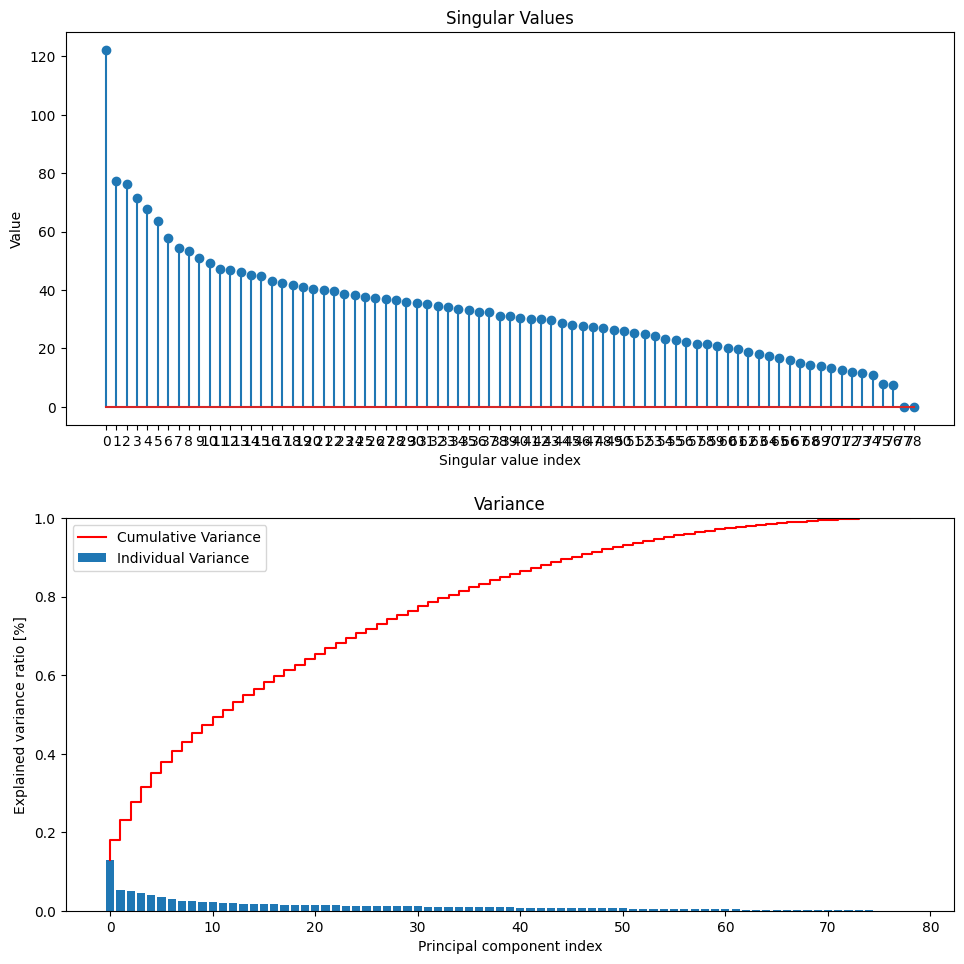

In [101]:
singular_values = pca.singular_values_
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
print(cumulative_explained_variance_ratio)

# plotting the singular values and the histogram of the explained varainces
fig = plt.figure(figsize=(10,10))
plt.subplot(211)
plt.stem(singular_values)
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xticks(np.arange(0,len(singular_values),1))
plt.title("Singular Values")
plt.ylabel("Value")
plt.xlabel("Singular value index")
plt.subplot(212)
plt.bar(np.arange(0,len(explained_variance_ratio[:]),1), explained_variance_ratio[:], label="Individual Variance")
plt.step(np.arange(0,len(cumulative_explained_variance_ratio[:]),1),cumulative_explained_variance_ratio[:], label="Cumulative Variance", color='r')
# plt.xticks([0,1,2,3,4])
plt.title("Variance")
plt.ylabel("Explained variance ratio [%]")
plt.xlabel("Principal component index")
plt.legend()
plt.ylim((0,1))
fig.tight_layout(pad=2)

# N. References

- Predicting House Prices (Keras - ANN), Tomas Mantero, https://www.kaggle.com/code/tomasmantero/predicting-house-prices-keras-ann/notebook
- 